In [1]:
import cv2
import numpy as np
import pandas as pd
import math
from scipy import signal
from scipy.ndimage import convolve
from PIL import Image
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = "C:\\Users\\30len\\bakalarka\\eyetrackingdata\\eyetrackingdata\\fixdens\\Raw\\"
part_names = ['alex', 'analene', 'brian', 'brian2', 'dan', 'david', 'fu', 'henrik', 'jasmin','kcheng', 'mark', 'michelle', 'mike', 'mohamed', 'neil', 'roshanak', 'ryan', 'terry', 'xiao', 'zoreh']
#processed som nepouzila
sum_names = len(part_names)
pict_no = 1
name_counter = 0

#path = "C:\\Users\\30len\\bakalarka\\eyetrackingdata\\eyetrackingdata\\fixdens\\Raw\\brian\\1.fix"
#potrebujem poskladat cestu ako je uvedene vyssie, je potrebne ale menit meno a fixacie pre obrazky

In [3]:
def load_file(path):
    with open(path, "r") as file:  # Use file to refer to the file object
        data = file.read()
        rows = data.split("\n")
    return rows

In [4]:
def count_fixations(rows):
    fix_count = 0
    if "No fixations!" not in rows[8]:
        count = re.search("\d+", rows[8])
        fix_count = int(count.group(0))
    return fix_count

In [53]:
def ret_df_fix(rows, hodnota, df_fix, part_index):
    counter = 1
    nazov = "fix_"
    nova_fix = ""
    x = []
    y = []
    
    for index, row in enumerate(rows):
        if ((index >=12) and (index < (12 + hodnota))):
            #iba riadky s fixaciami
            match_fix = re.findall(r'\d+', row)
            x_pos = int(match_fix[1])
            y_pos = int(match_fix[2])
            if ((x_pos > 1024) or (x_pos < 0) or (y_pos > 768) or (y_pos < 0)): #hodnoty mimo obraz
                vysledok = -1
            else:
                x.append(x_pos)
                y.append(y_pos)
                vysledok = x_pos * 1024 + y_pos
            nova_fix = nazov + str(counter)
            counter = counter + 1
#             print("nova fixacia nazov", nova_fix, "counter", counter)
            if nova_fix not in df_fix:
#                 df_fix[nova_fix] = np.nan 
                df_fix[nova_fix] = -1
            df_fix.loc[part_index][nova_fix] = vysledok
    
#     print("fix_count", fix_count, "participant index ", part_index)
    plt.ylim(0, 768)
    plt.xlim(0, 1024)
    plt.scatter(x, y)
    plt.title("participant cislo " + str(part_index))
    plt.show()
    return df_fix

In [54]:
# new_arr = sorted(set(d['df_fix_1']['fixation_count']))
# if (min(new_arr) == 0):
#     new_arr.remove(0)
# new_arr

df_fix_1


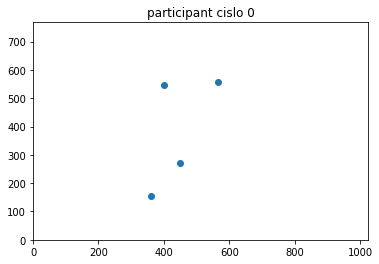

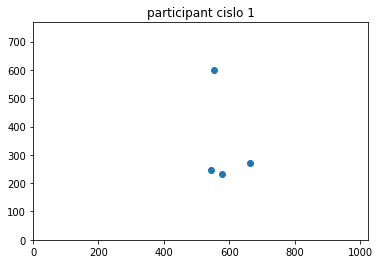

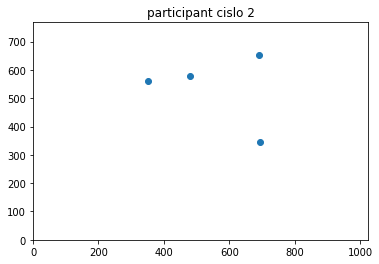

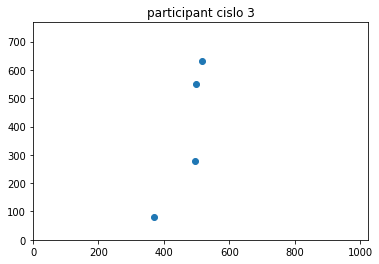

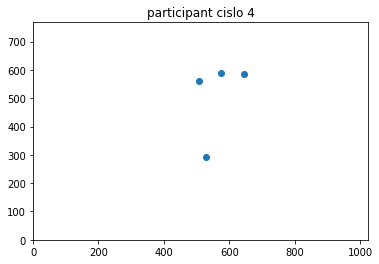

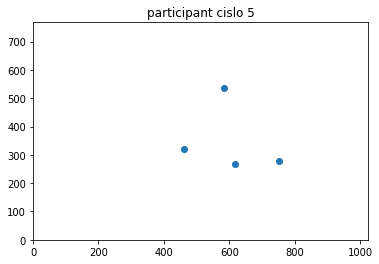

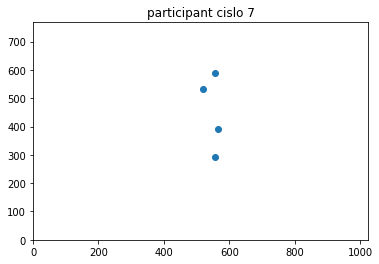

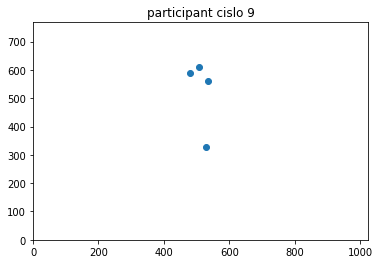

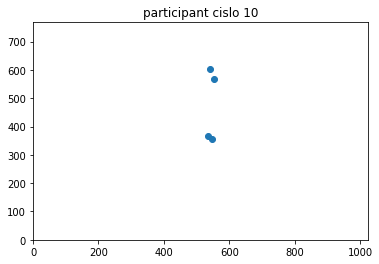

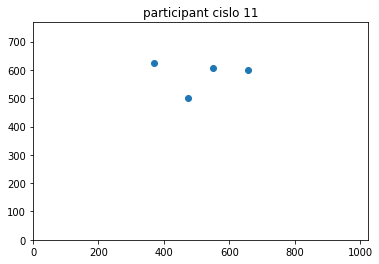

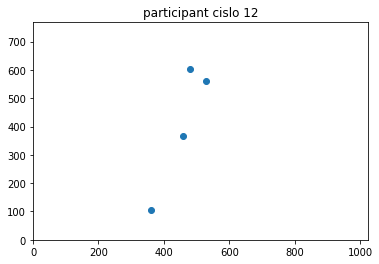

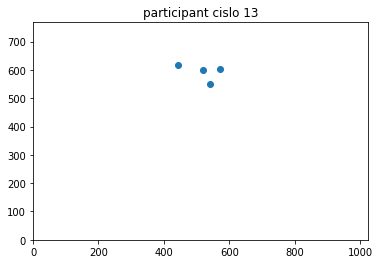

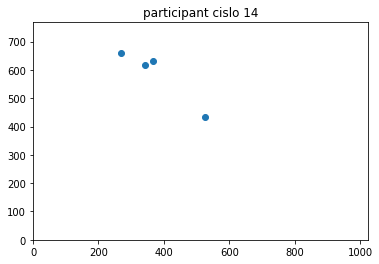

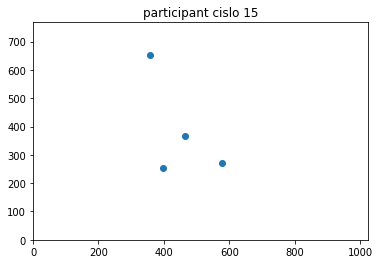

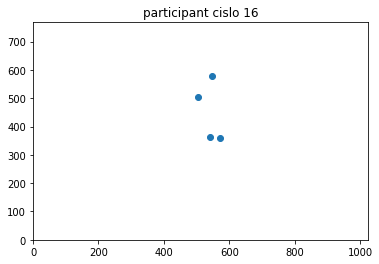

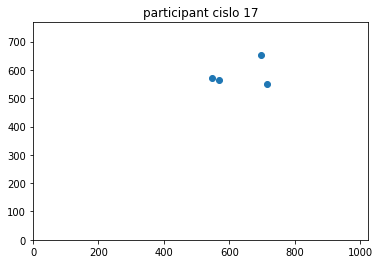

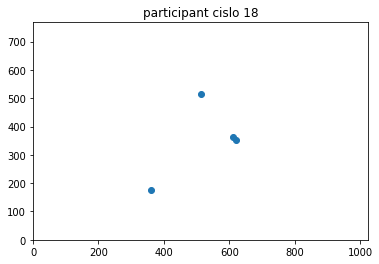

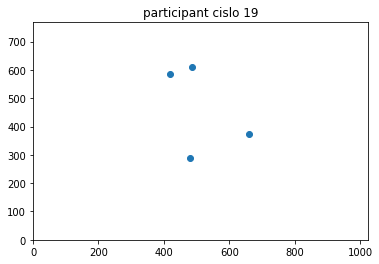

,fix_1,fix_2,fix_3,fix_4
0,460046,369820,580140,410148
1,558326,566871,593128,678160
2,492099,361010,708235,711001
3,508184,511528,530038,378961
4,541990,519729,662090,590413
5,473407,597527,632075,770328
7,569638,580998,533014,568908
9,542023,493134,518754,549426
10,547183,565816,554586,560485
11,486902,563806,674392,379504


In [55]:
zakladny_nazov = "df_fix_"
d = {}
    
for index in range(1): #normalne bude range po 120, lebo mame 120 obrazkov
    print(zakladny_nazov + str(index+1))
    novy_nazov = zakladny_nazov + str(index+1)
    d[novy_nazov] = pd.DataFrame(index=range(0, sum_names))
    nazov = "fix_1"
    d[novy_nazov][nazov] = -1

    fix_count_arr = []
#     tuto treba urobit magic, kolko fixacii budem chciet
    nahradit_hodnotou = 4
    
    for index_2, name in enumerate(part_names):
        path = base_path + part_names[index_2] + "\\" + str(index+1) + ".fix"
        rows = load_file(path)
        fix_count = count_fixations(rows)
        fix_count_arr.append(fix_count)
        
        #magic, kolko fixacii chcem v dataframe by mal byt tu!
        
    for index_3, fix in enumerate(fix_count_arr):
        if (fix >= nahradit_hodnotou):
            path = base_path + part_names[index_3] + "\\" + str(index+1) + ".fix"
            rows = load_file(path)
            d[novy_nazov] = ret_df_fix(rows, nahradit_hodnotou, d[novy_nazov], index_3)
        
#     d[novy_nazov]['fixation_count'][index_2] = fix_count
#       print(d[novy_nazov]['fixation_count'][index_2])

# Get names of indexes for which column .. has value -1
indexNames = d['df_fix_1'][ d['df_fix_1']['fix_4'] == -1 ].index #este osetrit, v podstate kdekolvek moze byt -1, ak je fixacia mimo obraz
# print(indexNames)
# Delete these row indexes from dataFrame
d['df_fix_1'].drop(indexNames , inplace=True)
d['df_fix_1']
# fix_count_arr

In [68]:
arr = d['df_fix_1'].as_matrix(columns=d['df_fix_1'].columns[:])
Z = np.vstack(arr)
Z

C:\Users\30len\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[460046, 369820, 580140, 410148],
       [558326, 566871, 593128, 678160],
       [492099, 361010, 708235, 711001],
       [508184, 511528, 530038, 378961],
       [541990, 519729, 662090, 590413],
       [473407, 597527, 632075, 770328],
       [569638, 580998, 533014, 568908],
       [542023, 493134, 518754, 549426],
       [547183, 565816, 554586, 560485],
       [486902, 563806, 674392, 379504],
       [471408, 542258, 493148, 368745],
       [554533, 454251, 533080, 587355],
       [540082, 376438, 349800, 277140],
       [476527, 368270, 405759, 592142],
       [559683, 587112, 555370, 515577],
       [560699, 715406, 731687, 583222],
       [526850, 635231, 369840, 626028],
       [428616, 498275, 675188, 492833]], dtype=int64)

In [69]:
# convert to np.float32
Z = np.float32(Z)

In [70]:
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [71]:
ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [72]:
# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
label

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [73]:
# d['df_fix_1']['fix_1']

In [74]:
#spatne vypocitanie fixacii a pridanie do pola
x = []
y = []

for i in range(4):
    for index, value in enumerate(d['df_fix_1']['fix_'+str(i+1)]):
        temp_fix = value #vypocitanie spatne suradnic x a y
        temp_x = int(temp_fix / 1024)
        temp_y = temp_fix % 1024
        x.append(temp_x)
        y.append(temp_y)

In [75]:
# upravenie labelov, aby sa s nimi dalo pracovat
# print(x)
# print(y)
array = label.flatten()
array = array.tolist()
array = array *4
# array

[449, 545, 480, 496, 529, 462, 556, 529, 534, 475, 460, 541, 527, 465, 546, 547, 514, 418, 361, 553, 352, 499, 507, 583, 567, 481, 552, 550, 529, 443, 367, 359, 573, 698, 620, 486, 566, 579, 691, 517, 646, 617, 520, 506, 541, 658, 481, 520, 341, 396, 542, 714, 361, 659, 400, 662, 694, 370, 576, 752, 555, 536, 547, 370, 360, 573, 270, 578, 503, 569, 611, 481]
[270, 246, 579, 280, 294, 319, 294, 327, 367, 502, 368, 549, 434, 367, 579, 571, 514, 584, 156, 599, 562, 552, 561, 535, 390, 590, 568, 606, 562, 619, 630, 654, 360, 654, 351, 611, 556, 232, 651, 630, 586, 267, 534, 610, 602, 600, 604, 600, 616, 255, 362, 551, 176, 372, 548, 272, 345, 81, 589, 280, 588, 562, 357, 624, 105, 603, 660, 270, 505, 566, 364, 289]


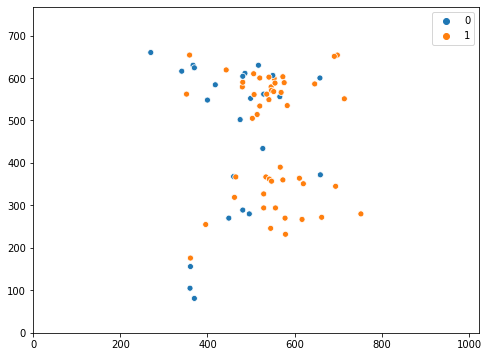

In [76]:
#zobrazenie konkretnych fixacii s farebnym rozlisenim pre zhluky
plt.figure(figsize=(8,6))
plt.ylim(0, 768)
plt.xlim(0, 1024)
sns.scatterplot(x, y, hue=array)